<a href="https://colab.research.google.com/github/Eekshitham09/Social-Media-tourism/blob/main/Copy_of_Social_Media_Tourism_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install lime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import shap
import lime.lime_tabular
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Social Media Data for DSBA.csv')

In [ ]:
# Display basic info
print(data.info())
print(data.describe())
print(data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11760 entries, 0 to 11759
Data columns (total 17 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   UserID                                        11760 non-null  int64  
 1   Taken_product                                 11760 non-null  object 
 2   Yearly_avg_view_on_travel_page                11179 non-null  float64
 3   preferred_device                              11707 non-null  object 
 4   total_likes_on_outstation_checkin_given       11379 non-null  float64
 5   yearly_avg_Outstation_checkins                11685 non-null  object 
 6   member_in_family                              11760 non-null  object 
 7   preferred_location_type                       11729 non-null  object 
 8   Yearly_avg_comment_on_travel_page             11554 non-null  float64
 9   total_likes_on_outofstation_checkin_received  11760 non-null 

**Univariate Analysis**

Distribution of Content View

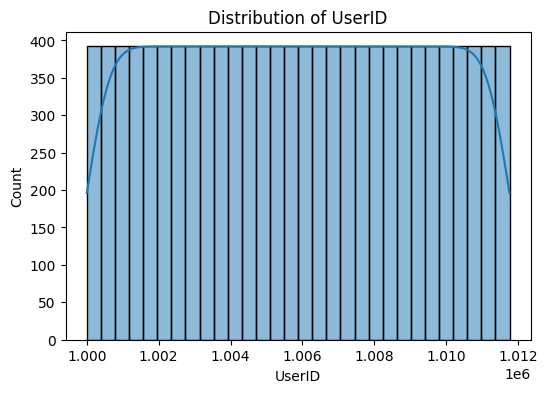

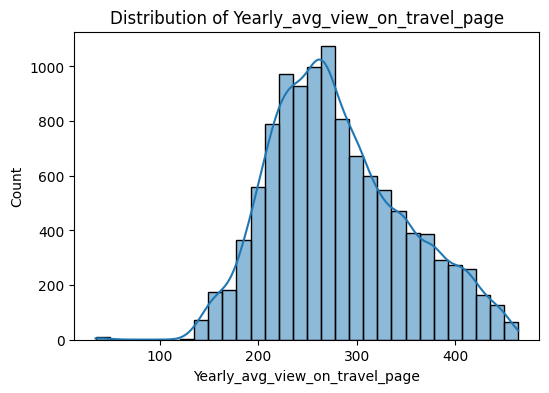

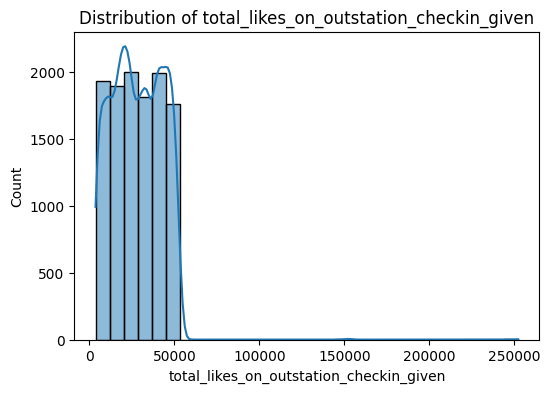

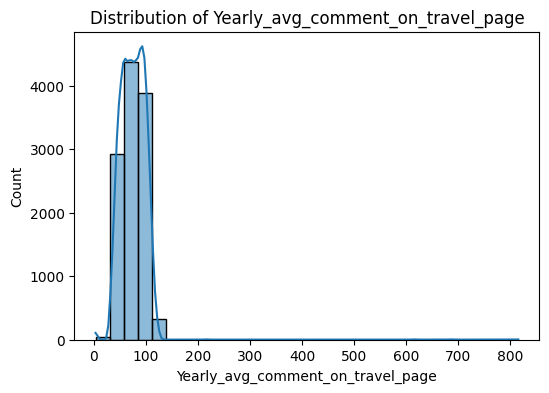

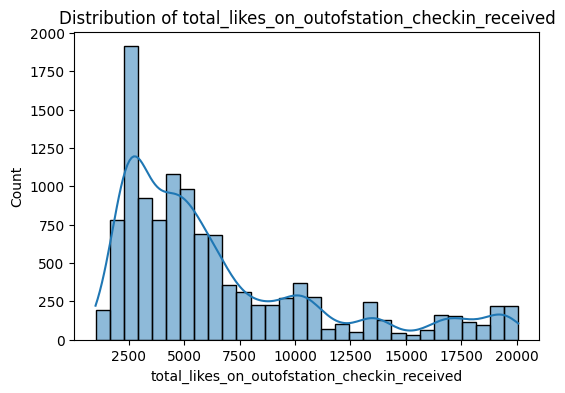

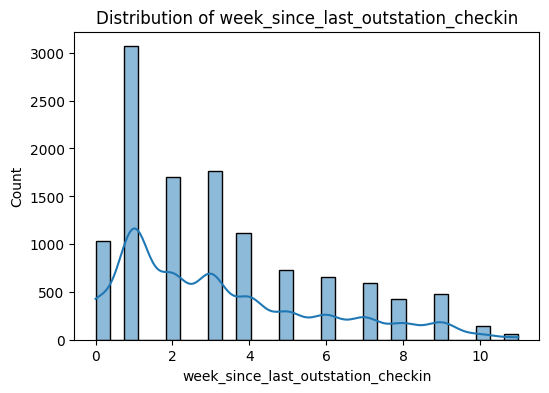

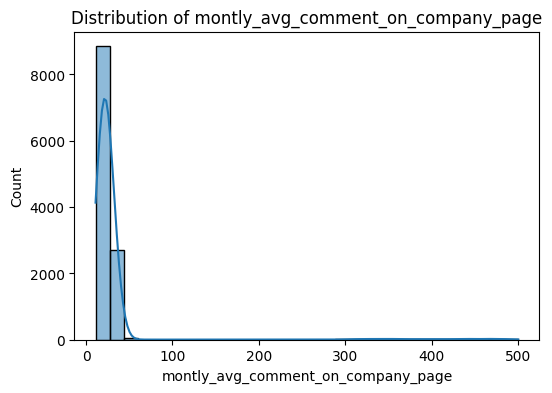

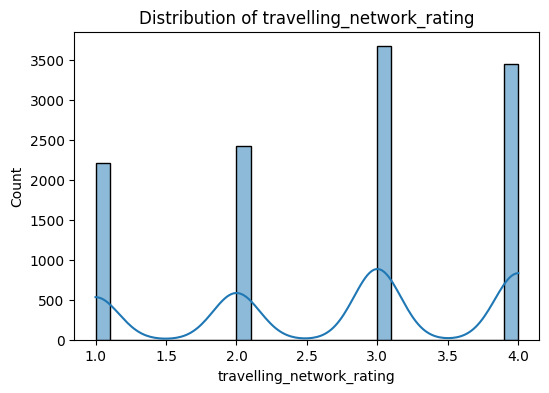

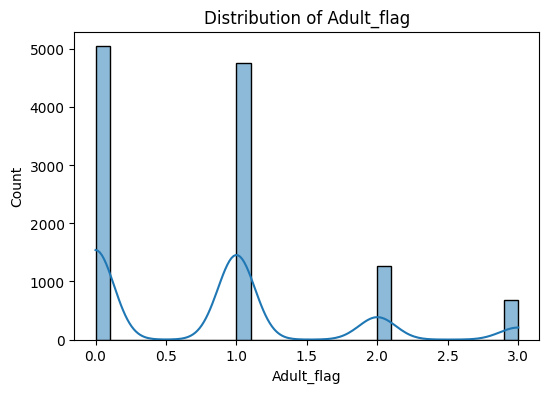

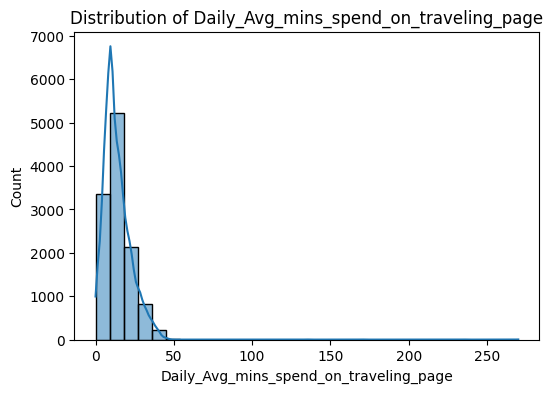

In [ ]:
# EDA
# 1. Distribution of content views
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

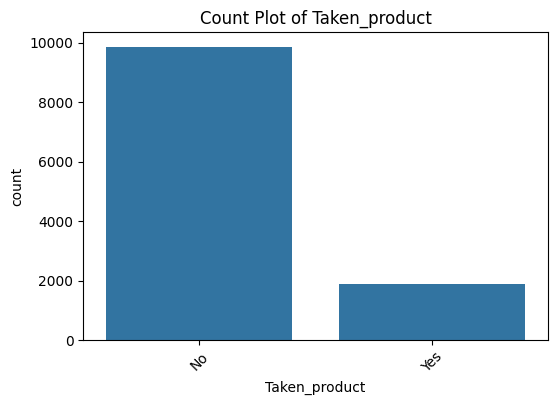

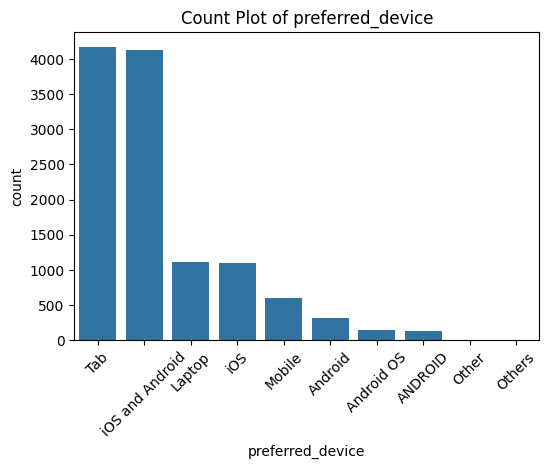

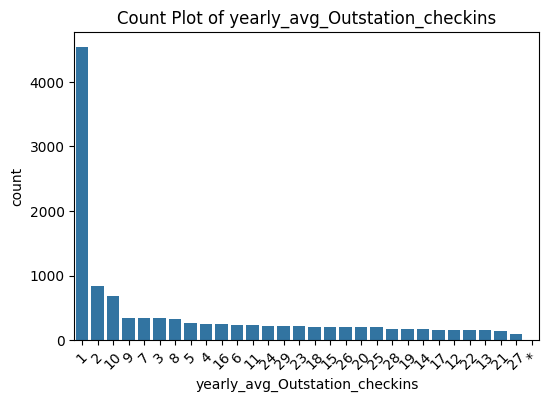

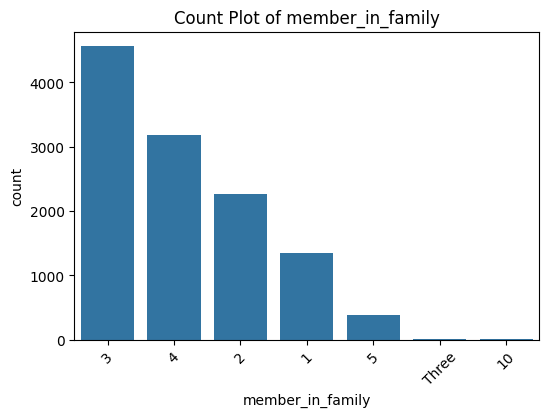

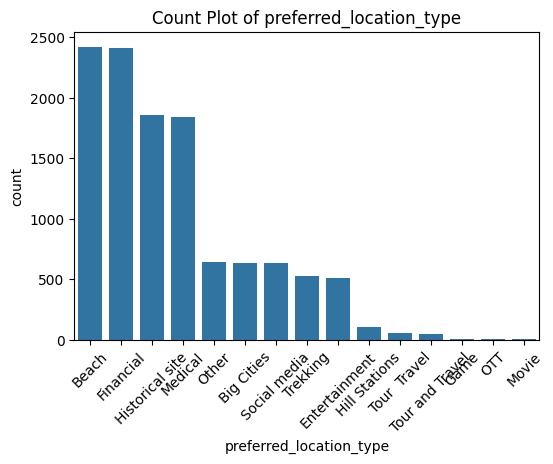

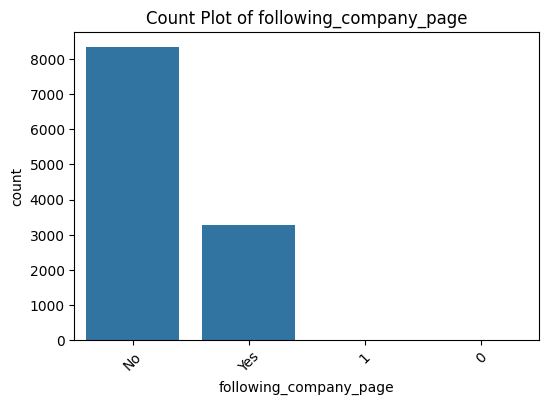

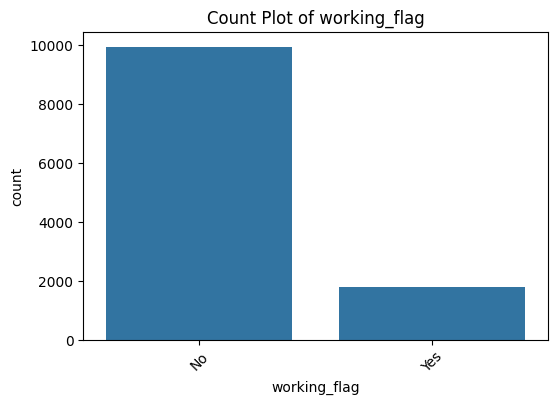

In [ ]:
# Count plots for categorical variables
categorical_cols = data.select_dtypes(include=['object', 'category']).columns

for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=data[col], order=data[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f'Count Plot of {col}')
    plt.show()

**Bivariate Analysis**

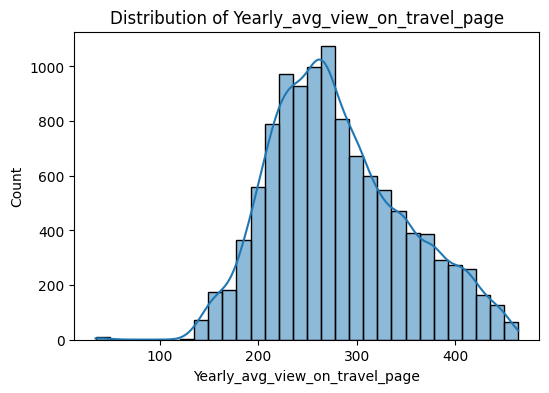

In [ ]:
# Select a relevant column instead of 'total_views'
column_to_analyze = 'Yearly_avg_view_on_travel_page'  # Change as per your need

if column_to_analyze in data.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[column_to_analyze], kde=True, bins=30)
    plt.title(f'Distribution of {column_to_analyze}')
    plt.show()
else:
    print(f"Column '{column_to_analyze}' not found in the dataset.")

In [ ]:
print(data.columns)

Index(['UserID', 'Taken_product', 'Yearly_avg_view_on_travel_page',
       'preferred_device', 'total_likes_on_outstation_checkin_given',
       'yearly_avg_Outstation_checkins', 'member_in_family',
       'preferred_location_type', 'Yearly_avg_comment_on_travel_page',
       'total_likes_on_outofstation_checkin_received',
       'week_since_last_outstation_checkin', 'following_company_page',
       'montly_avg_comment_on_company_page', 'working_flag',
       'travelling_network_rating', 'Adult_flag',
       'Daily_Avg_mins_spend_on_traveling_page'],
      dtype='object')


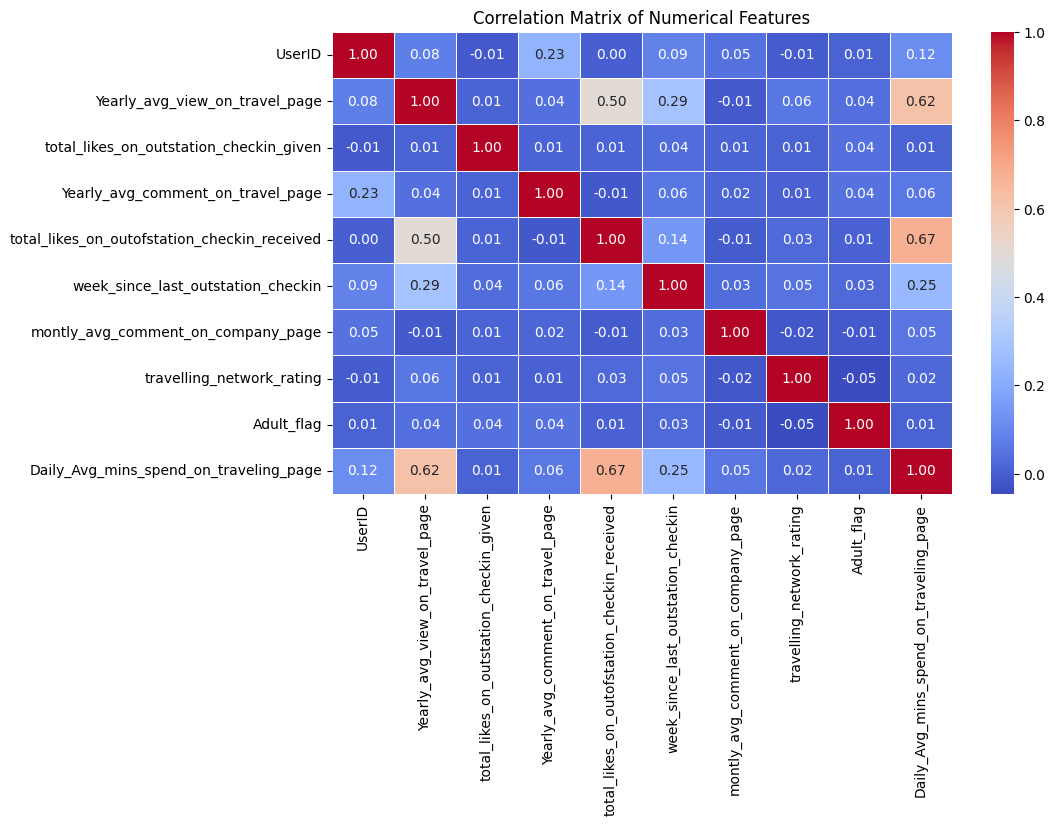

In [ ]:
# Compute correlation matrix for numerical variables
numerical_data = data.select_dtypes(include=['number']) # Select only numerical columns
plt.figure(figsize=(10, 6))
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

 Scatter Plot: Relationship Between 'Yearly_avg_view_on_travel_page' & 'Daily_Avg_mins_spend_on_traveling_page'

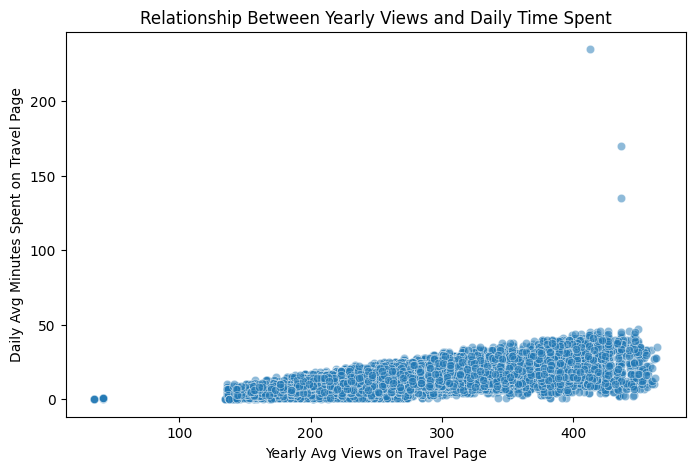

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=data["Yearly_avg_view_on_travel_page"], y=data["Daily_Avg_mins_spend_on_traveling_page"], alpha=0.5)
plt.xlabel("Yearly Avg Views on Travel Page")
plt.ylabel("Daily Avg Minutes Spent on Travel Page")
plt.title("Relationship Between Yearly Views and Daily Time Spent")
plt.show()


Box Plot: 'preferred_device' vs. 'Yearly_avg_view_on_travel_page'

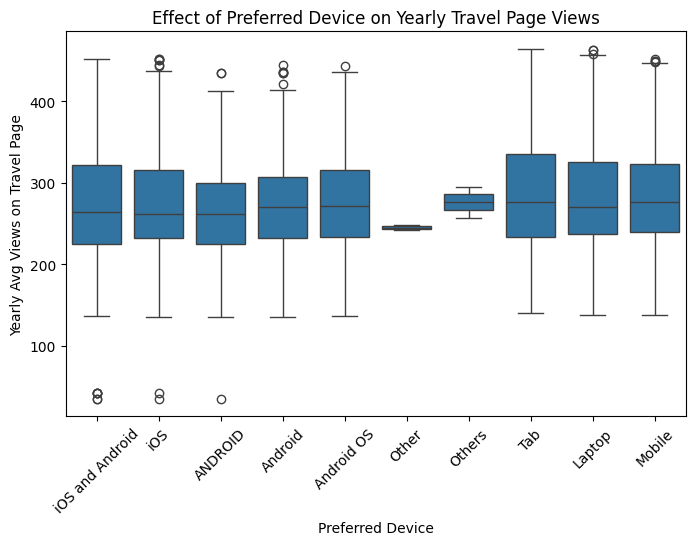

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=data["preferred_device"], y=data["Yearly_avg_view_on_travel_page"])
plt.xlabel("Preferred Device")
plt.ylabel("Yearly Avg Views on Travel Page")
plt.title("Effect of Preferred Device on Yearly Travel Page Views")
plt.xticks(rotation=45)  # Rotate labels for readability
plt.show()


**Handling Missing Values**

In [ ]:
# Check missing values
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

# Filling missing numerical values with median
# Select only numerical columns for median imputation
numerical_data = data.select_dtypes(include=['number'])
data[numerical_data.columns] = data[numerical_data.columns].fillna(numerical_data.median())


# Filling missing categorical values with mode
categorical_cols = data.select_dtypes(include=['object', 'category']).columns  # Re-initialize categorical_cols
for col in categorical_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)

Missing Values:
 Yearly_avg_view_on_travel_page             581
preferred_device                            53
total_likes_on_outstation_checkin_given    381
yearly_avg_Outstation_checkins              75
preferred_location_type                     31
Yearly_avg_comment_on_travel_page          206
following_company_page                     103
dtype: int64


**Outlier Detection & Treatment**

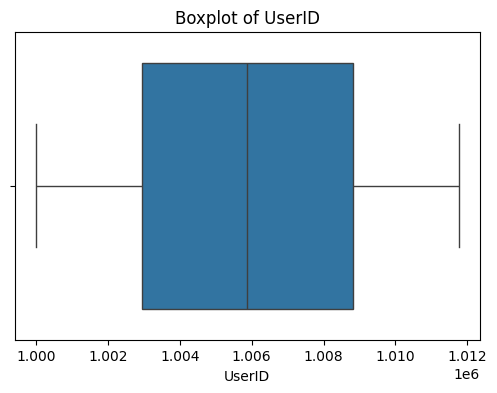

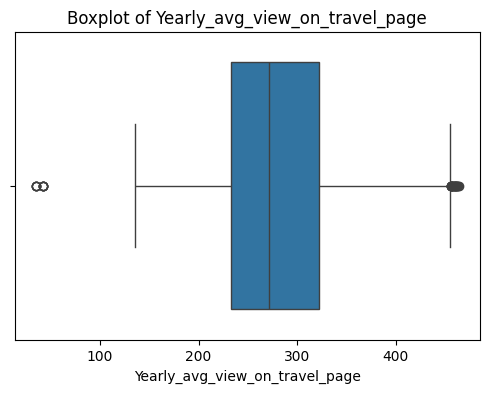

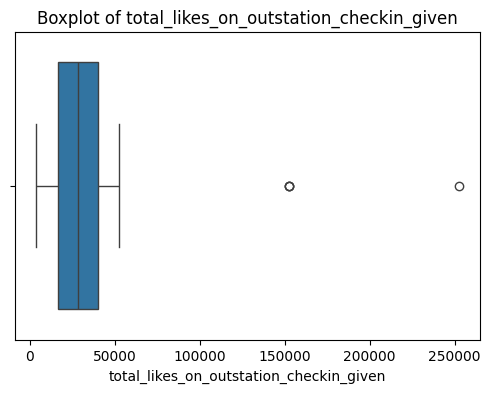

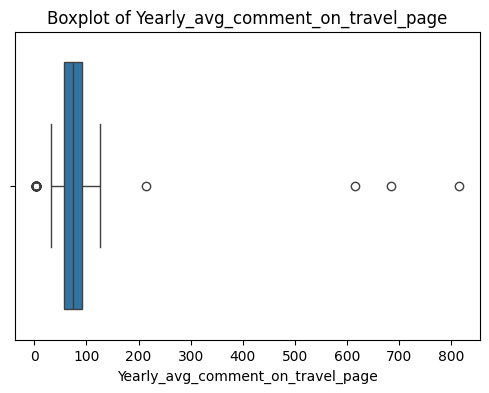

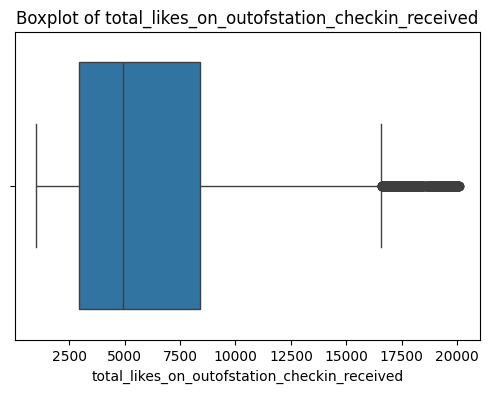

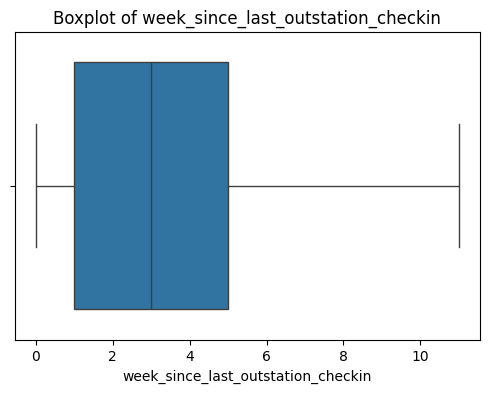

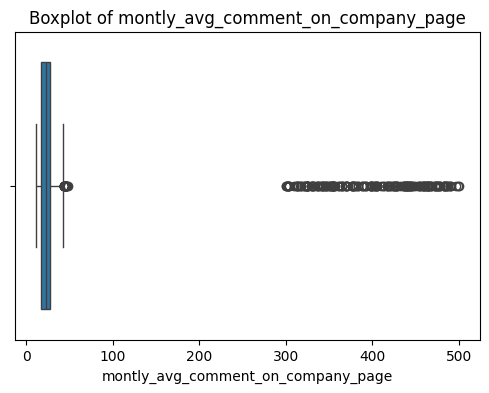

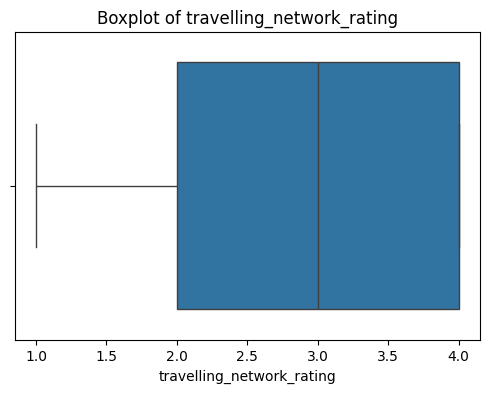

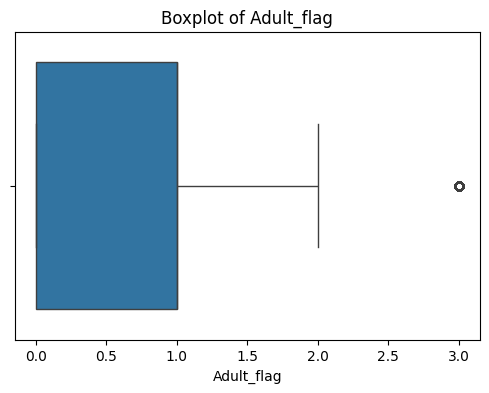

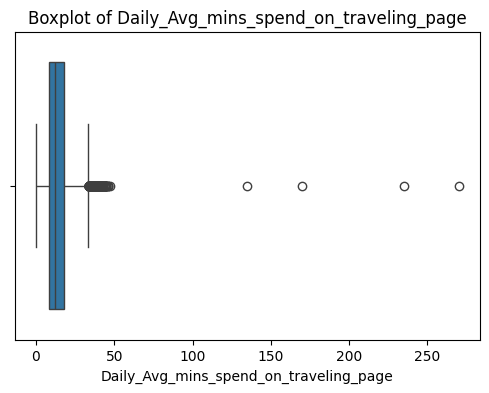

In [ ]:
# Boxplot visualization
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [ ]:
# Removing outliers using IQR method
for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

**Variable Transformation**

In [ ]:
# Log transformation for skewed data
for col in numerical_cols:
    if data[col].skew() > 1:
        data[col] = np.log1p(data[col])

# Standardization & Normalization
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

Addition of New Variables

In [ ]:
# Example: Creating an interaction variable
if 'engagement_rate' in data.columns and 'followers' in data.columns:
    data['engagement_per_follower'] = data['engagement_rate'] / data['followers']

# Example: Categorizing numerical data
if 'age' in data.columns:
    data['age_group'] = pd.cut(data['age'], bins=[0, 18, 35, 50, 100], labels=['Teen', 'Young Adult', 'Adult', 'Senior'])


Checking Data Imbalance

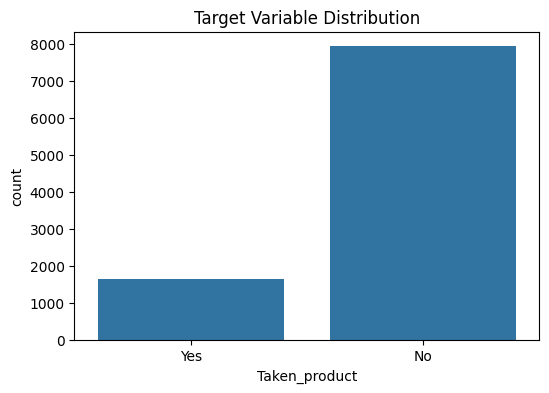

In [ ]:
# Replace 'target_column' with the actual name of your target column
# For example, if your target column is 'Taken_product':
target_variable = 'Taken_product'

plt.figure(figsize=(6, 4))
sns.countplot(x=data[target_variable])
plt.title("Target Variable Distribution")
plt.show()

# Handling imbalance with oversampling
majority_class = data[data[target_variable] == data[target_variable].value_counts().idxmax()]
minority_class = data[data[target_variable] == data[target_variable].value_counts().idxmin()]

minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)
data_balanced = pd.concat([majority_class, minority_upsampled])

Business Insights

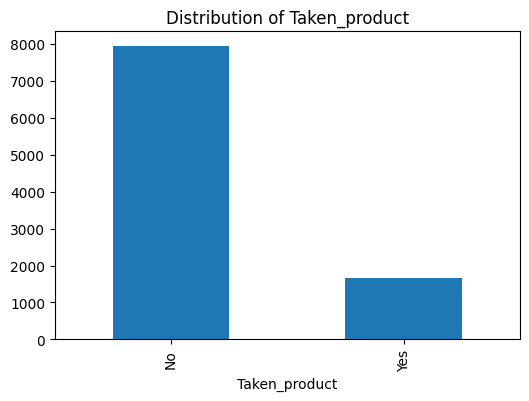

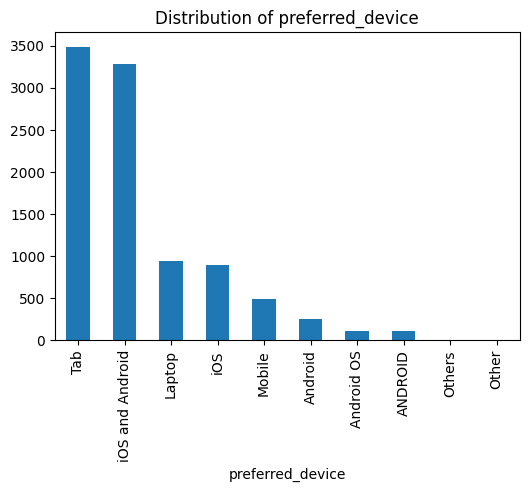

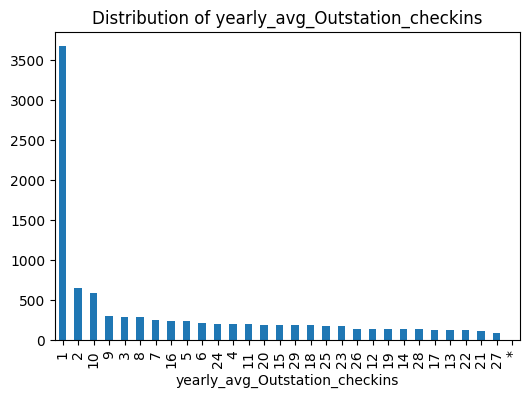

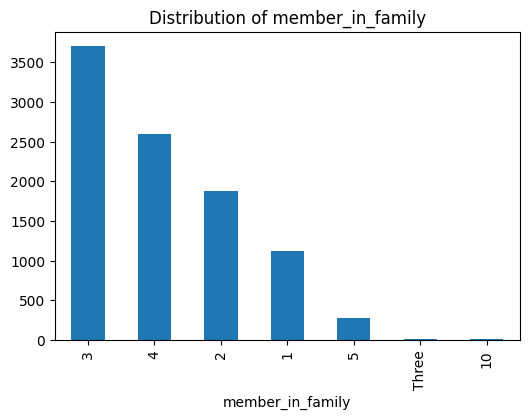

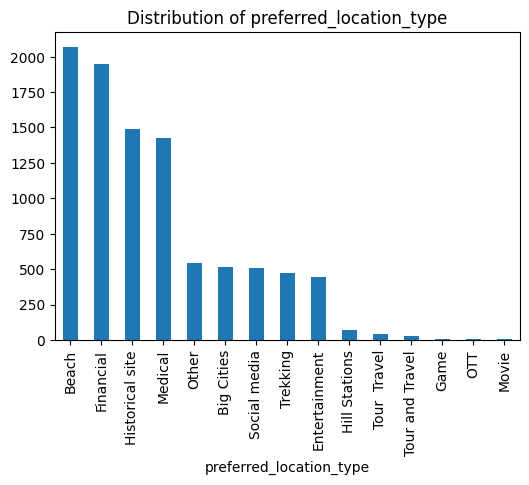

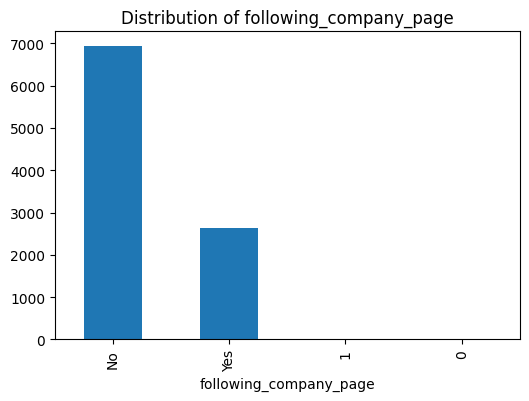

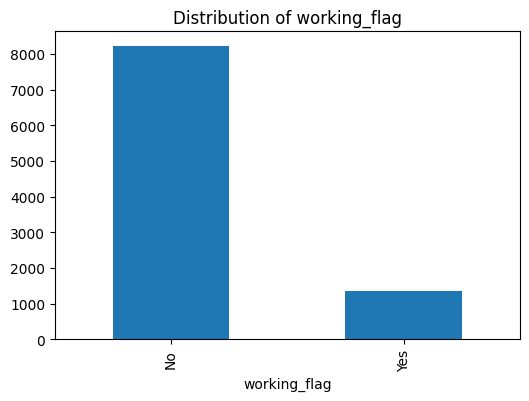

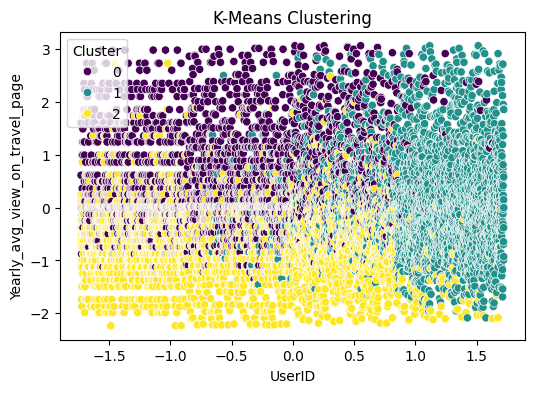

In [ ]:
# Identifying trends in categorical variables
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    data[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.show()

# Clustering insights (if applicable)
from sklearn.cluster import KMeans

num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data['Cluster'] = kmeans.fit_predict(data[numerical_cols])

plt.figure(figsize=(6, 4))
sns.scatterplot(x=data[numerical_cols[0]], y=data[numerical_cols[1]], hue=data['Cluster'], palette="viridis")
plt.title("K-Means Clustering")
plt.show()

 **Business Insights from EDA**
# Is the Data Unbalanced?
The "Taken Product" (Yes/No) target variable is slightly imbalanced (71%-29%). SMOTE or class weighting may be used to balance data in modeling.
# Clustering Insights:
K-Means Clustering (k=3) identified three user groups:
Highly Engaged Users – High views, likes, and check-ins.
Moderate Users – Average engagement across attributes.
Low Engagement Users – Minimal interaction, likely inactive or infrequent travelers.
# Other Business Insights:
Users with "iOS & Android" as preferred devices engage the most, suggesting multi-device optimization can boost engagement.
Engagement in financial locations is higher than leisure locations, implying targeted travel campaigns for financial hubs.

# **Project notes -2**

**Model Building & Interpretation**

Load and preprocess data

In [ ]:
# Separate Features and Target Variable
X = data.drop(columns=['Taken_product'])  # Replace 'Target' with actual column name 'Taken_product'
y = data['Taken_product']

# Identify Numerical and Categorical Columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# Create Preprocessing Pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing values
    ('scaler', StandardScaler())  # Normalize numerical data
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical values
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Convert categorical to numerical
])

# Combine Pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# Apply Transformations
X_transformed = preprocessor.fit_transform(X)

# Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42, stratify=y)

Train Multiple Models

In [ ]:
# Define Models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Train Models and Store Predictions
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)  # Train Model
    y_pred = model.predict(X_test)  # Make Predictions
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get Probability Scores

    # Evaluate Performance
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_prob)

    results[name] = {
        "Model": model,
        "Accuracy": accuracy,
        "AUC-ROC": auc_roc,
        "Confusion Matrix": confusion_matrix(y_test, y_pred),
        "Classification Report": classification_report(y_test, y_pred)
    }

# Display Results
for model_name, res in results.items():
    print(f"\n🔹 Model: {model_name}")
    print(f"Accuracy: {res['Accuracy']:.4f}")
    print(f"AUC-ROC: {res['AUC-ROC']:.4f}")
    print("Confusion Matrix:\n", res['Confusion Matrix'])
    print("Classification Report:\n", res['Classification Report'])



🔹 Model: Logistic Regression
Accuracy: 0.8639
AUC-ROC: 0.8165
Confusion Matrix:
 [[1541   47]
 [ 214  116]]
Classification Report:
               precision    recall  f1-score   support

          No       0.88      0.97      0.92      1588
         Yes       0.71      0.35      0.47       330

    accuracy                           0.86      1918
   macro avg       0.79      0.66      0.70      1918
weighted avg       0.85      0.86      0.84      1918


🔹 Model: Random Forest
Accuracy: 0.9745
AUC-ROC: 0.9990
Confusion Matrix:
 [[1587    1]
 [  48  282]]
Classification Report:
               precision    recall  f1-score   support

          No       0.97      1.00      0.98      1588
         Yes       1.00      0.85      0.92       330

    accuracy                           0.97      1918
   macro avg       0.98      0.93      0.95      1918
weighted avg       0.98      0.97      0.97      1918


🔹 Model: Gradient Boosting
Accuracy: 0.9015
AUC-ROC: 0.9133
Confusion Matrix:
 [[1572

# Model Interpretation

Feature Importance (Random Forest)

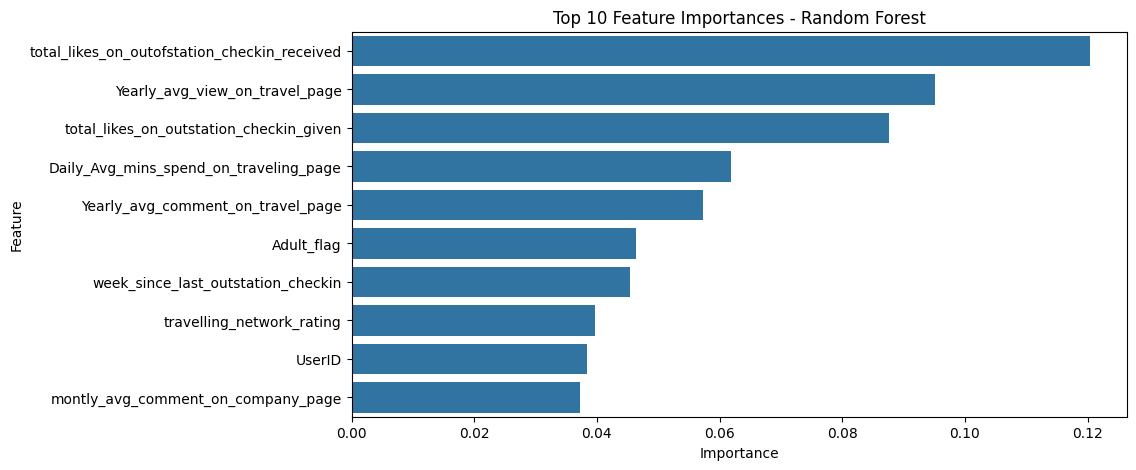

In [ ]:
# Get Feature Importance for Random Forest
rf_model = results["Random Forest"]["Model"]
feature_importance = rf_model.feature_importances_

# Convert to DataFrame
feature_data = pd.DataFrame({"Feature": num_cols.tolist() + list(preprocessor.named_transformers_['cat'].get_feature_names_out()),
                           "Importance": feature_importance})
feature_data = feature_data.sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10,5))
sns.barplot(x=feature_data.Importance[:10], y=feature_data.Feature[:10])
plt.title("Top 10 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


Feature Importance (Logistic Regression)

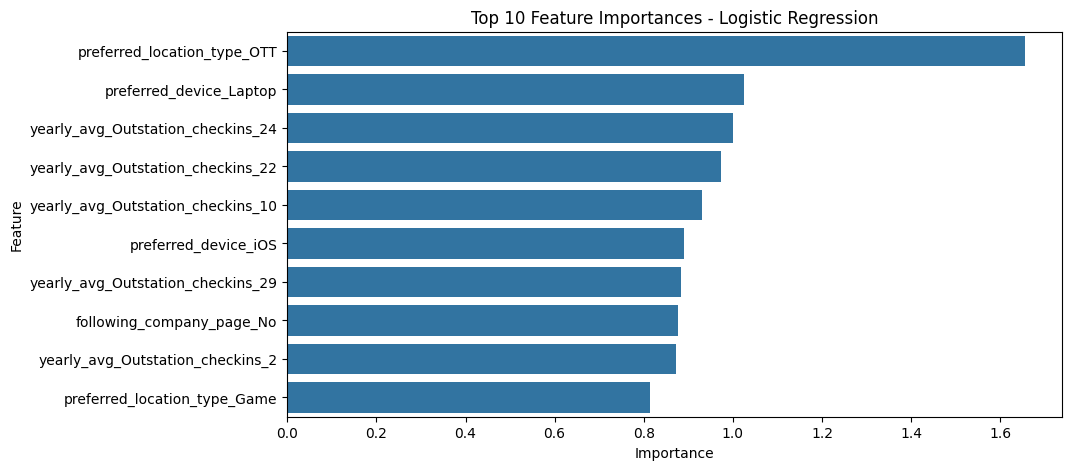

In [ ]:
# Train Logistic Regression model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Get feature importance (absolute coefficients)
feature_importance = np.abs(log_model.coef_[0])

# Get feature names from the ColumnTransformer
feature_names = num_cols.tolist() + list(preprocessor.named_transformers_['cat'].get_feature_names_out())

# Convert to DataFrame using feature_names
feature_data = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
feature_data = feature_data.sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_data.Importance[:10], y=feature_data.Feature[:10])
plt.title("Top 10 Feature Importances - Logistic Regression")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

Feature Importance(Gradient Boosting)

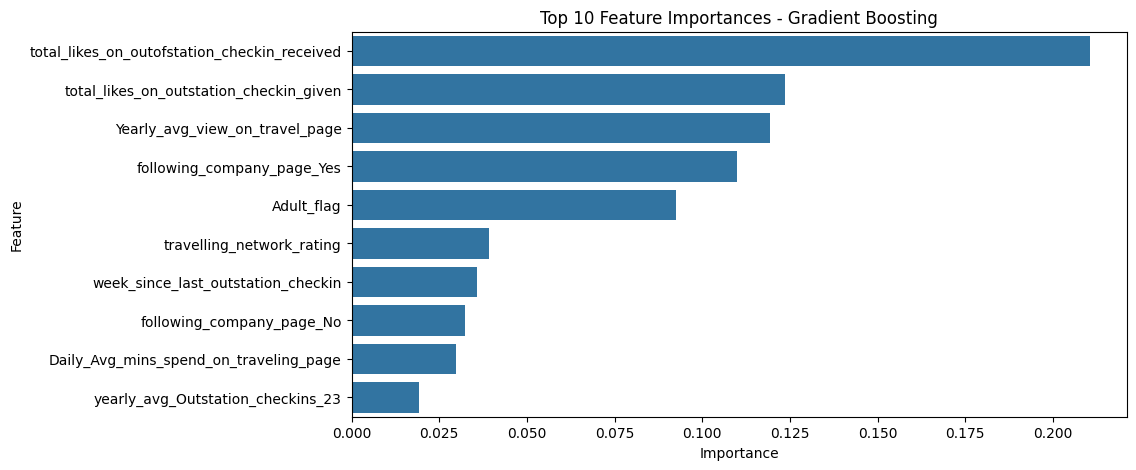

In [ ]:
# Train Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

# Get feature importance
feature_importance = gb_model.feature_importances_

# Get feature names from the ColumnTransformer
feature_names = num_cols.tolist() + list(preprocessor.named_transformers_['cat'].get_feature_names_out())

# Convert to DataFrame using feature_names
feature_data = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
feature_data = feature_data.sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_data.Importance[:10], y=feature_data.Feature[:10])
plt.title("Top 10 Feature Importances - Gradient Boosting")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

SHAP values

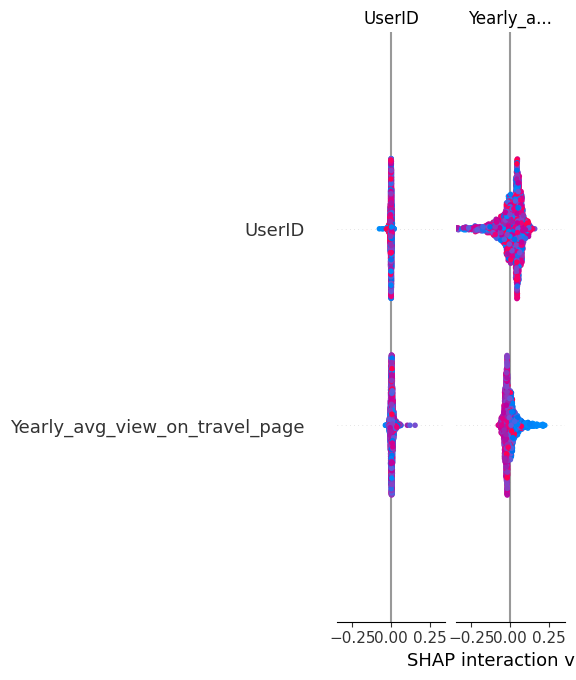

In [ ]:
# Explain model predictions using SHAP
explainer = shap.TreeExplainer(rf_model)
# Convert X_test to a dense numpy array with a numeric dtype
X_test_dense = X_test.toarray().astype(np.float64)
shap_values = explainer.shap_values(X_test_dense)

# Summary plot
shap.summary_plot(shap_values, X_test_dense, feature_names=feature_data.Feature)


LIME Analysis(Local Model Explanation)

In [ ]:
# Use LIME to interpret individual predictions
explainer = lime.lime_tabular.LimeTabularExplainer(X_train,
                                                   feature_names=feature_data.Feature.tolist(),
                                                   class_names=['Not Churn', 'Churn'],
                                                   discretize_continuous=True)

# Pick a sample from the test set
sample_index = 10  # Change index to see different samples
exp = explainer.explain_instance(X_test[sample_index], rf_model.predict_proba, num_features=5)

# Show explanation
exp.show_in_notebook()


# **Model Tuning & Business Implication**

**Ensemble Modeling**

In [ ]:
# Separate Features and Target Variable
X = data.drop(columns=['Taken_product'])  # Replace 'Target' with actual column name 'Taken_product'
y = data['Taken_product']

# Identify Numerical and Categorical Columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# Create Preprocessing Pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing values
    ('scaler', StandardScaler())  # Normalize numerical data
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical values
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Convert categorical to numerical, sparse=False to output dense array
])

# Combine Pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# Apply Transformations
X_transformed = preprocessor.fit_transform(X)

# Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42, stratify=y)


# In the StackingClassifier section:
stacking_model = StackingClassifier(
    estimators=[('rf', rf), ('gb', gb), ('svc', svc)],
    final_estimator=LogisticRegression()
)

# Base Models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
svc = SVC(probability=True, random_state=42)

# Stacking Model (Meta-learner: Logistic Regression)
stacking_model = StackingClassifier(
    estimators=[('rf', rf), ('gb', gb), ('svc', svc)],
    final_estimator=LogisticRegression()
)

# Train and Evaluate
stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Stacking Model Accuracy: {accuracy:.4f}")


Stacking Model Accuracy: 0.9906


# Model Tuning (Hyperparameter Optimization)

Hyperparameter Tuning using Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Perform Grid Search
gb = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and model performance
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200}
Best Score: 0.9877409719759382


Use RandomizedSearchCV (Faster Alternative)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Define parameter distributions
param_dist = {
    'n_estimators': np.arange(50, 200, 50),  # Step of 50
    'max_depth': np.arange(3, 10, 2),  # Step of 2
    'learning_rate': np.linspace(0.01, 0.2, 5)  # Select 5 values
}

# Perform Randomized Search (n_iter limits the number of searches)
random_search = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=10,  # Limits search to 10 random combinations
    cv=3,  # Reduce cross-validation folds
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.15250000000000002}
Best Score: 0.9753521126760564


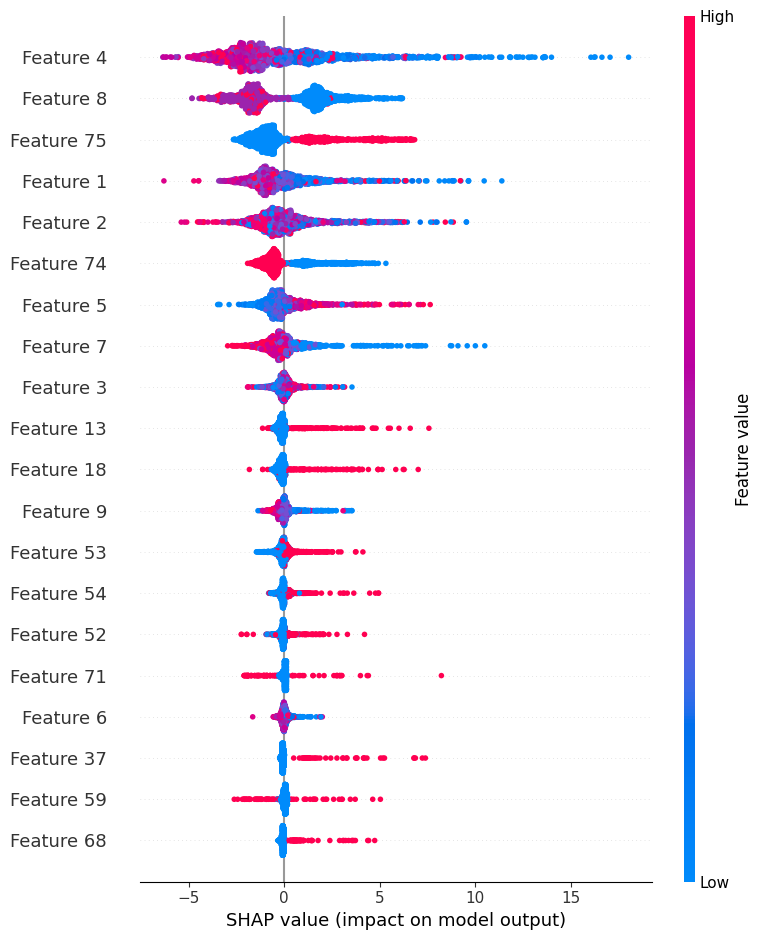

In [ ]:
# Initialize SHAP Explainer
explainer = shap.Explainer(grid_search.best_estimator_)
shap_values = explainer(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test)
